# Intro

Some experiments to get a good score for the [Identify Age-Related Conditions][0] kaggle competition using various models.

Start by importing commonly used modules that make it convenient to work with the fastai library. Some will be patched to make them work in non-standard ways but improve interactivity.

[0]: https://www.kaggle.com/competitions/icr-identify-age-related-conditions

In [1]:
from fastai.imports import *
from fastai.tabular.all import *

# Data Inspection

Get the dataset appropriately whether we're in kaggle or not. If in kaggle, it is assumed the competition dataset has been connected to the notebook.

In [2]:
import os
competition_name = "icr-identify-age-related-conditions"

is_kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if is_kaggle:
    path = Path(f"/kaggle/input/{competition_name}")
else:
    import zipfile, kaggle
    path = Path.home() / '.kaggle' / 'input' / competition_name
    kaggle.api.competition_download_cli(competition_name, path=path.parent)
    zipfile.ZipFile(f'{path}.zip').extractall(path)

icr-identify-age-related-conditions.zip: Skipping, found more recently modified local copy (use --force to force download)


Load the datasets. It's a small dataset so we can set the `low_memory` pandas flag to `False`.

In [3]:
path.ls()

(#4) [Path('/home/krm/.kaggle/input/icr-identify-age-related-conditions/test.csv'),Path('/home/krm/.kaggle/input/icr-identify-age-related-conditions/greeks.csv'),Path('/home/krm/.kaggle/input/icr-identify-age-related-conditions/train.csv'),Path('/home/krm/.kaggle/input/icr-identify-age-related-conditions/sample_submission.csv')]

In [4]:
df_train = pd.read_csv(f'{path}/train.csv', low_memory=False)
df_test = pd.read_csv(f'{path}/test.csv', low_memory=False)
df_train.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [5]:
df_train.columns

Index(['Id', 'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Class'],
      dtype='object')

We can now examine the data.

In [6]:
df_train.describe()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,...,616.000000,617.000000,615.000000,617.000000,617.000000,617.000000,617.000000,617.000000,616.000000,617.000000
mean,0.477149,3502.013221,118.624513,38.968552,10.128242,5.545576,0.060320,10.566447,8.053012,5350.388655,...,5.433199,3.533905,0.421501,20.724856,131.714987,14679.595398,31.489716,50.584437,8.530961,0.175041
std,0.468388,2300.322717,127.838950,69.728226,10.518877,2.551696,0.416817,4.350645,65.166943,3021.326641,...,11.496257,50.181948,1.305365,9.991907,144.181524,19352.959387,9.864239,36.266251,10.327010,0.380310
min,0.081187,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,1693.624320,...,0.173229,0.497060,0.067730,4.102182,72.611063,13.038894,9.432735,0.897628,0.001129,0.000000
25%,0.252107,2197.345480,85.200147,12.270314,8.138688,4.128294,0.025578,8.129580,1.229900,4155.702870,...,0.173229,0.497060,0.067730,14.036718,72.611063,2798.992584,25.034888,23.011684,0.124392,0.000000
50%,0.354659,3120.318960,85.200147,20.533110,8.138688,5.031912,0.025578,10.461320,1.229900,4997.960730,...,3.028141,1.131000,0.250601,18.771436,72.611063,7838.273610,30.608946,41.007968,0.337827,0.000000
75%,0.559763,4361.637390,113.739540,39.139886,8.138688,6.431634,0.036845,12.969516,5.081244,6035.885700,...,6.238814,1.512060,0.535067,25.608406,127.591671,19035.709240,36.863947,67.931664,21.978000,0.000000
max,6.161666,28688.187660,1910.123198,630.518230,178.943634,38.270880,10.315851,38.971568,1463.693448,53060.599240,...,137.932739,1244.227020,31.365763,135.781294,1497.351958,143790.071200,81.210825,191.194764,21.978000,1.000000


We see that the mean of the dependant column `Class` is much closer to zero than one. This means that the observations with a positive diagnosis are smaller in proportion in the training data. We confirm this by plotting a pie chart for column `Class`.

<Axes: ylabel='count'>

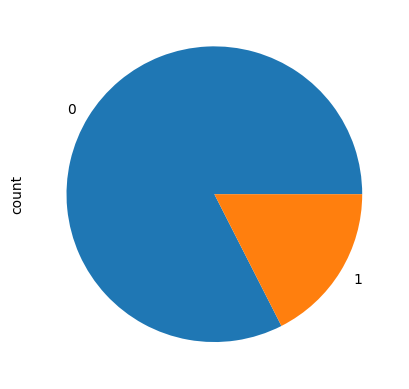

In [7]:
%matplotlib inline

df_train.Class.value_counts().plot.pie()

We also check for null values

In [8]:
df_train.isna().sum()

Id        0
AB        0
AF        0
AH        0
AM        0
AR        0
AX        0
AY        0
AZ        0
BC        0
BD        0
BN        0
BP        0
BQ       60
BR        0
BZ        0
CB        2
CC        3
CD        0
CF        0
CH        0
CL        0
CR        0
CS        0
CU        0
CW        0
DA        0
DE        0
DF        0
DH        0
DI        0
DL        0
DN        0
DU        1
DV        0
DY        0
EB        0
EE        0
EG        0
EH        0
EJ        0
EL       60
EP        0
EU        0
FC        1
FD        0
FE        0
FI        0
FL        1
FR        0
FS        2
GB        0
GE        0
GF        0
GH        0
GI        0
GL        1
Class     0
dtype: int64

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

 # Data Processing
 
We'll use fastai's `TabularPandas` object to simplify data processing. We need to categorify the categorical columns, and fill in missing continuous values.

We'll do this on a tabular object over the entire dataset so that we get data transformations that will work on all dataset rows, and re-use these on per-fold data splits.

We want the fill-missing transformations to assume any of the X columns can be null. We therefore add a dummy row of all null values.

In [10]:
procs = [Categorify, FillMissing]
cat_names = ["Id", "EJ"]
ycol = "Class"
cont_names = [c for c in df_train.columns if not c in cat_names + [ycol]]

dummy_row = pd.DataFrame([[None] * 57 + [1]], columns=df_train.columns)
df_dummy = pd.concat([df_train, dummy_row], ignore_index=True)
df_dummy

tb_base = TabularPandas(df_dummy, procs, cat_names, cont_names, y_names=ycol)

/home/krm/projects/icr-competition/.env/lib/python3.8/site-packages/fastai/tabular/core.py:314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to.loc[:,n+'_na'] = missing[n]
/home/krm/projects/icr-competition/.env/lib/python3.8/site-packages/fastai/tabular/core.py:314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to.loc[:,n+'_na'] = missing[n]
/home/krm/projects/icr-competition/.env/lib/python3.8/site-packages/fastai/tabular/core.py:314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `

Now that processors can act on any-null row values, we can re-use them on the actual training data set.

In [11]:
tb_train = tb_base.new(df_train)
tb_train.process()
train_xs = tb_train.xs
train_y = tb_train.y
train_xs.shape, train_y.shape, df_train.shape

((617, 112), (617,), (617, 58))

# Modeling - Histogram Boosting Gradient Classifier

Because of the small dataset size and imbalanced classes, we'll use stratified K-fold for our train/test splits. 

The competition uses the balanced log loss metric which is explained more [here][0]. For our purposes, we'll use the simple implementation.

[0]: https://www.kaggle.com/competitions/icr-identify-age-related-conditions/discussion/422442

In [12]:
from sklearn.metrics import log_loss
def balanced_log_loss(y_true, y_pred):
    nc = np.bincount(y_true)
    return log_loss(y_true, y_pred, sample_weight = 1/nc[y_true], eps=1e-15)

def m_log_loss(model, xs, y): return balanced_log_loss(np.array(y), np.array(model.predict(xs)))

For each fold, we train and validate a model and collect the metrics. To start with, we'll train with the gradient booster with default parameters to establish a baseline.

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import HistGradientBoostingClassifier

s_kfold = StratifiedKFold(n_splits=5)

In [14]:
models, accuracy = [], []
for train_idx, valid_idx in s_kfold.split(df_train, df_train.Class):

    fold_xs, fold_y = train_xs.iloc[train_idx], train_y.iloc[train_idx]
    fold_valid_xs, fold_valid_y = train_xs.iloc[valid_idx], train_y.iloc[valid_idx]
    
    gb = HistGradientBoostingClassifier()
    gb.fit(fold_xs, fold_y)
    
    accuracy.append(gb.score(fold_valid_xs, fold_valid_y))
    models.append(gb)
    
models, accuracy, np.mean(accuracy)

([HistGradientBoostingClassifier(),
  HistGradientBoostingClassifier(),
  HistGradientBoostingClassifier(),
  HistGradientBoostingClassifier(),
  HistGradientBoostingClassifier()],
 [0.9516129032258065,
  0.9112903225806451,
  0.926829268292683,
  0.9186991869918699,
  0.983739837398374],
 0.9384343036978755)

Let's see how the score compares to the log loss metric. (The HGB already uses the log_loss as the loss function)

In [15]:
models, metrics = [], []
for train_idx, valid_idx in s_kfold.split(df_train, df_train.Class):
    
    fold_train_xs, fold_train_y = train_xs.iloc[train_idx], train_y.iloc[train_idx]
    fold_valid_xs, fold_valid_y = train_xs.iloc[valid_idx], train_y.iloc[valid_idx]    
    
    gb = HistGradientBoostingClassifier()
    gb.fit(fold_train_xs, fold_train_y)
    
    metrics.append(m_log_loss(gb, fold_valid_xs, fold_valid_y))
    models.append(gb)
    
models, metrics, np.mean(metrics)

([HistGradientBoostingClassifier(),
  HistGradientBoostingClassifier(),
  HistGradientBoostingClassifier(),
  HistGradientBoostingClassifier(),
  HistGradientBoostingClassifier()],
 [4.094172600988403,
  6.172051923639091,
  5.222797144646798,
  6.264397673548952,
  1.6447036378528908],
 4.679624596135227)

Because of the class imbalance, we can instruct the boosting machine to use class weights.

In [16]:
gb_models, metrics, accuracy = [], [], []
for train_idx, valid_idx in s_kfold.split(df_train, df_train.Class):
    
    fold_train_xs, fold_train_y = train_xs.iloc[train_idx], train_y.iloc[train_idx]
    fold_valid_xs, fold_valid_y = train_xs.iloc[valid_idx], train_y.iloc[valid_idx]    
    
    gb = HistGradientBoostingClassifier(class_weight='balanced')
    gb.fit(fold_train_xs, fold_train_y)
    
    accuracy.append(gb.score(fold_valid_xs, fold_valid_y))
    metrics.append(m_log_loss(gb, fold_valid_xs, fold_valid_y))
    gb_models.append(gb)
    
gb_models, metrics, accuracy, np.mean(metrics), np.mean(accuracy)

([HistGradientBoostingClassifier(class_weight='balanced'),
  HistGradientBoostingClassifier(class_weight='balanced'),
  HistGradientBoostingClassifier(class_weight='balanced'),
  HistGradientBoostingClassifier(class_weight='balanced'),
  HistGradientBoostingClassifier(class_weight='balanced')],
 [3.647823704237536,
  3.817135351258816,
  2.0829083814731,
  6.264397673548952,
  1.3302867599902823],
 [0.9435483870967742,
  0.9354838709677419,
  0.959349593495935,
  0.9186991869918699,
  0.967479674796748],
 3.4285103741017373,
 0.9449121426698138)

This version of the GB model gives a mean accuracy of 0.94 and log loss score of 3.4 locally.

# Modeling - Random Forest Classifier

We can also do k-fold validation with a Random Forest and compare the results. 

In [17]:
from sklearn.ensemble import RandomForestClassifier


rf_models, oob_metrics = [], []
for train_idx, valid_idx in s_kfold.split(df_train, df_train.Class):
    
    fold_train_xs, fold_train_y = train_xs.iloc[train_idx], train_y.iloc[train_idx]
    fold_valid_xs, fold_valid_y = train_xs.iloc[valid_idx], train_y.iloc[valid_idx]    
    
    rf = RandomForestClassifier(n_estimators=300, oob_score=True, criterion="log_loss")
    rf.fit(fold_train_xs, fold_train_y)
    oob_preds = rf.oob_decision_function_
    oob_preds_class_1 = oob_preds[:,1]
    
    oob_metrics.append(balanced_log_loss(fold_train_y, oob_preds_class_1))
    rf_models.append(rf)

rf_models, oob_metrics, np.mean(oob_metrics)

([RandomForestClassifier(criterion='log_loss', n_estimators=300, oob_score=True),
  RandomForestClassifier(criterion='log_loss', n_estimators=300, oob_score=True),
  RandomForestClassifier(criterion='log_loss', n_estimators=300, oob_score=True),
  RandomForestClassifier(criterion='log_loss', n_estimators=300, oob_score=True),
  RandomForestClassifier(criterion='log_loss', n_estimators=300, oob_score=True)],
 [0.5007312905460624,
  0.46148978185387074,
  0.484568347584251,
  0.46519751337608506,
  0.4766976798413998],
 0.4777369226403338)

Gives the best score locally with the criterion set as `log_loss`. Adding `class_weight=balanced` makes it worse, but we need to validate this observation on the leaderboard.

We can plot the resulting feature importance list and compare it with previous attemtps

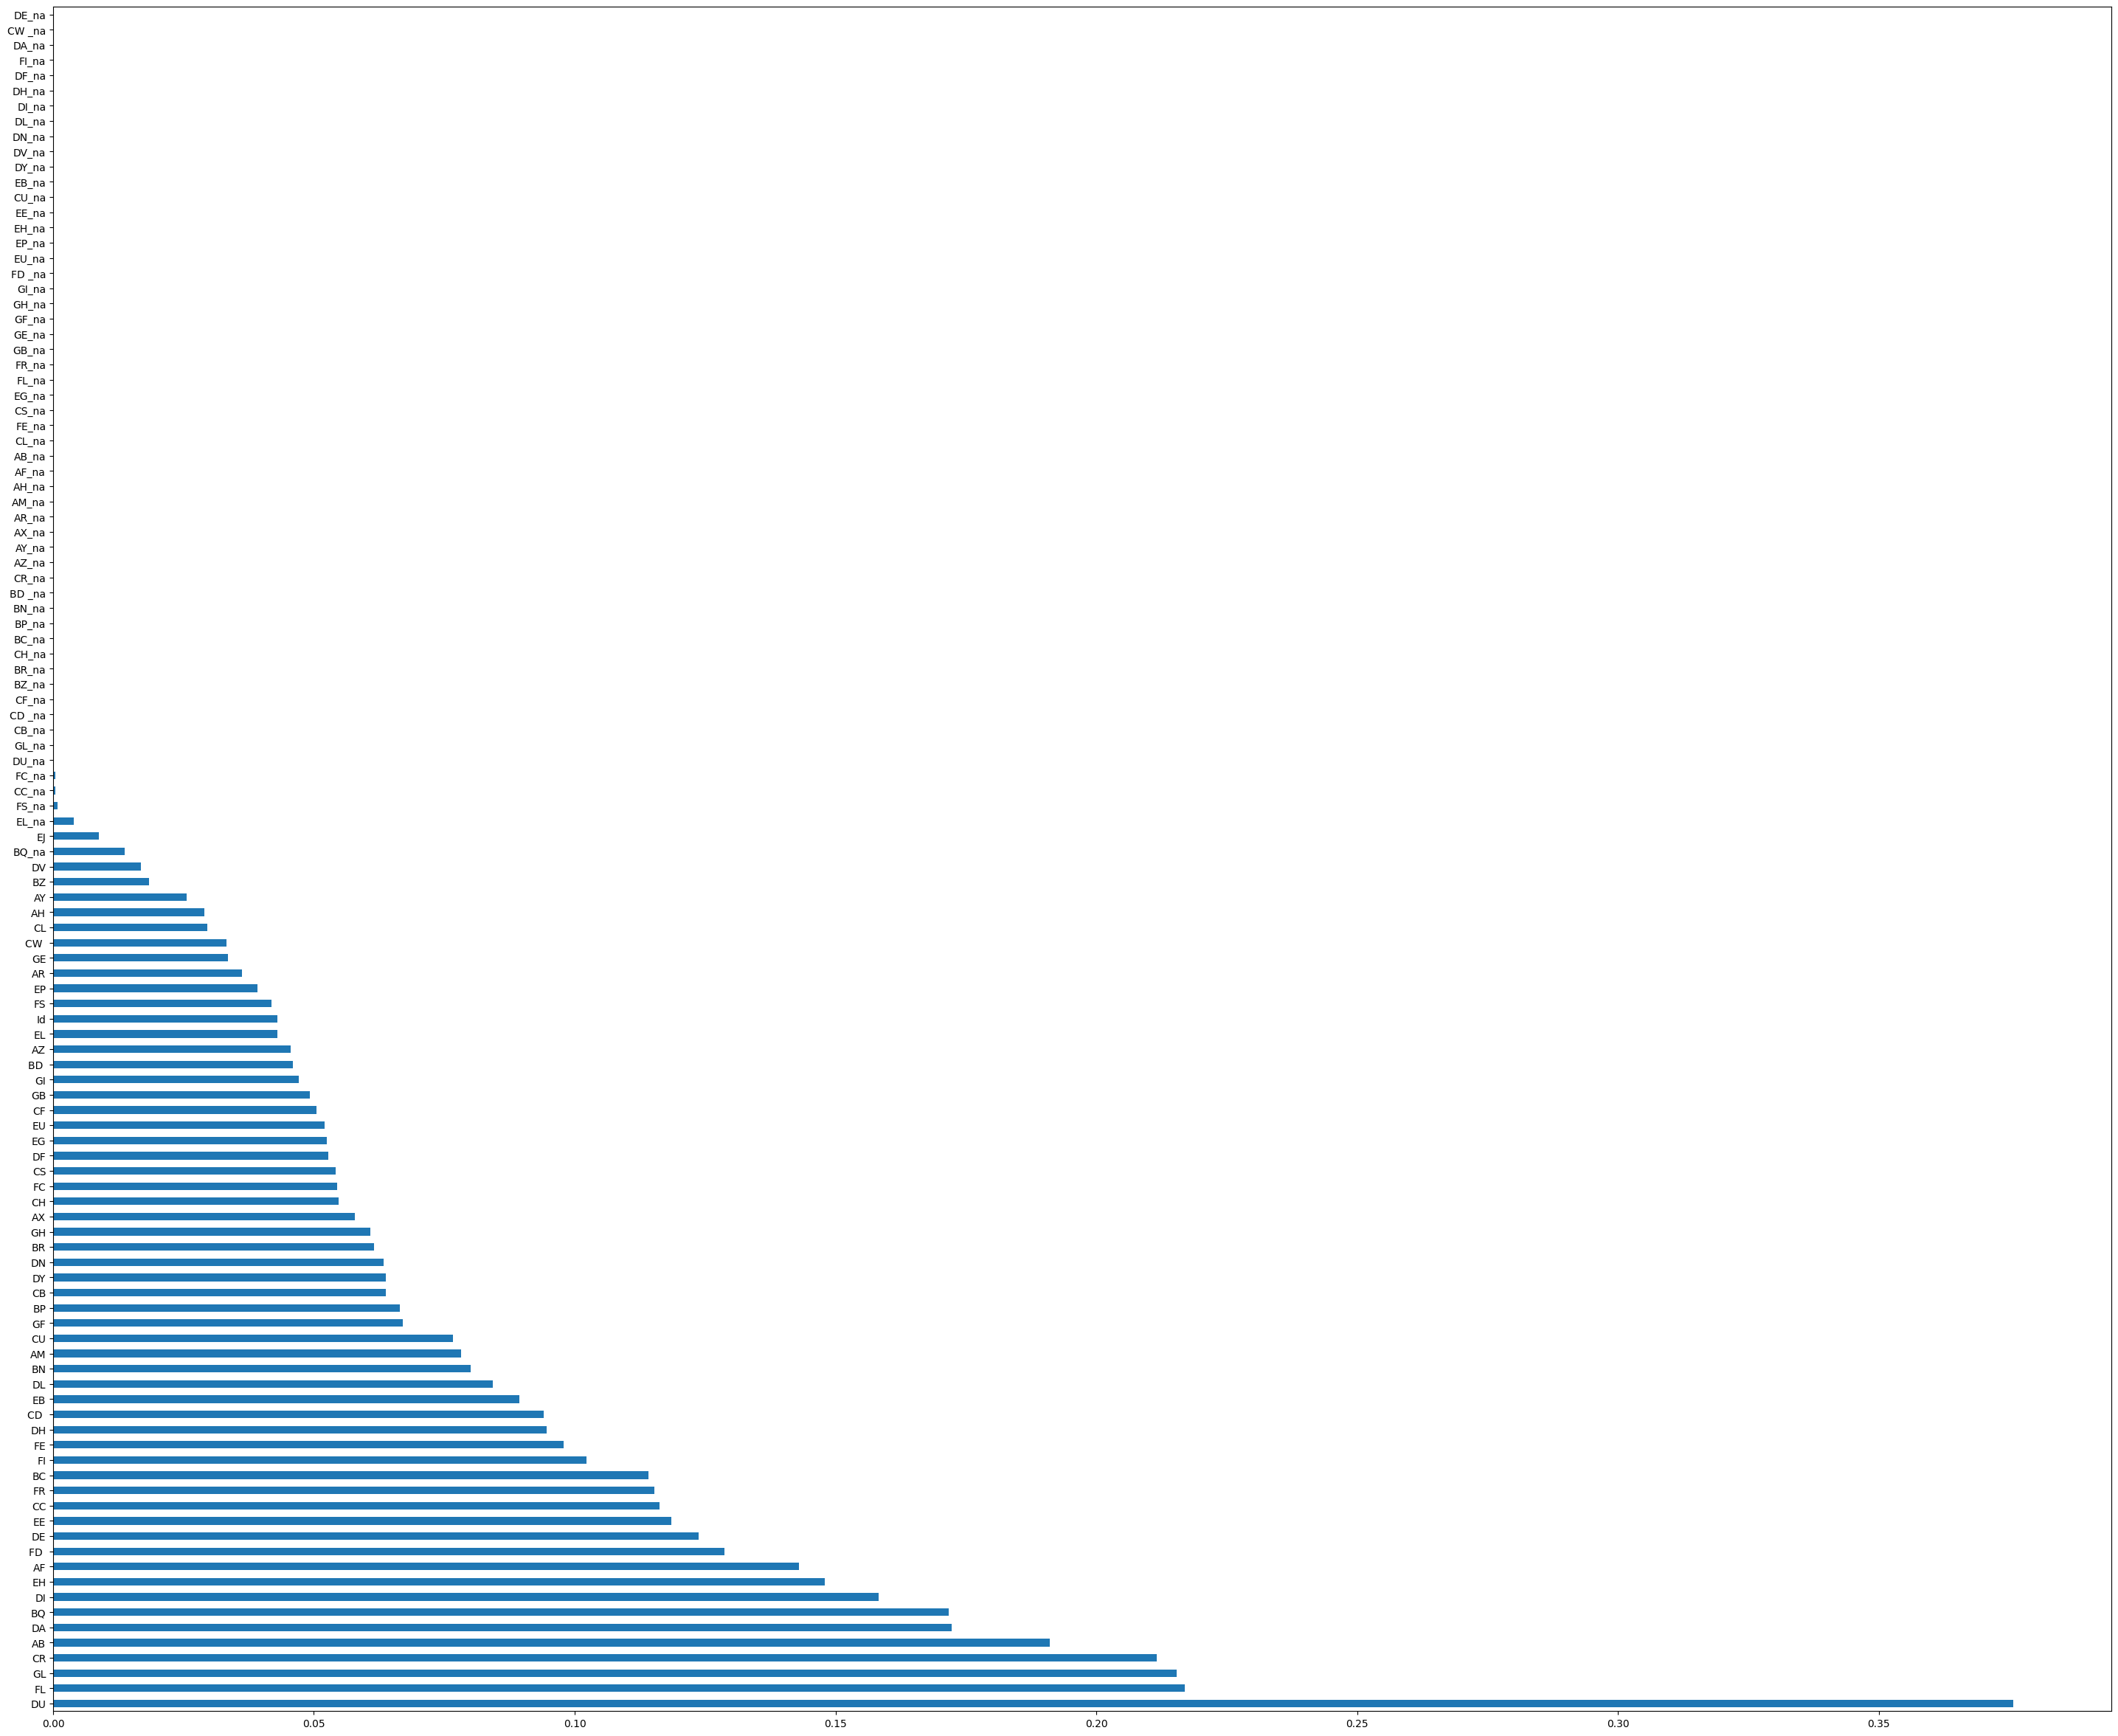

In [18]:
columns = [c for c in train_xs.columns]

importances = [m.feature_importances_ for m in rf_models]
feature_importance = pd.DataFrame(data=importances, columns=columns)
feature_importance = feature_importance.sum().sort_values(ascending=False)
feature_importance

def plot_feature_importance(feature_importance):
    feature_importance.plot(kind='barh', figsize=(36, 30))
    
plot_feature_importance(feature_importance)

# Modeling - Neural Network

Finally, we can train the neural network via fastai's `tabular_learner`, with stratified k-fold cross-validation.

We'll need to also normalize the data for the neural network, and add columns for na_values.

In [19]:
procs = [Normalize, FillMissing]

tb_base_nn = TabularPandas(df_dummy, procs, cat_names, cont_names, y_names=ycol)

/home/krm/projects/icr-competition/.env/lib/python3.8/site-packages/fastai/tabular/core.py:314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to.loc[:,n+'_na'] = missing[n]
/home/krm/projects/icr-competition/.env/lib/python3.8/site-packages/fastai/tabular/core.py:314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to.loc[:,n+'_na'] = missing[n]
/home/krm/projects/icr-competition/.env/lib/python3.8/site-packages/fastai/tabular/core.py:314: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `

In [20]:
tb_nn = tb_base_nn.new(df_train)
tb_nn.process()
df_train_nn = tb_nn.xs
df_train_nn[ycol] = tb_nn.y

cont_names_nn, cat_names_nn = cont_cat_split(df_train_nn, dep_var=ycol)

/tmp/ipykernel_27213/1208785579.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train_nn[ycol] = tb_nn.y


Next we account for the class weight

In [21]:
n_0, n_1 = np.bincount(df_train.Class)
w_0 = (n_0 + n_1) / (2.0 * n_0)
w_1 = (n_0 + n_1) / (2.0 * n_1)
class_weights_nn = torch.FloatTensor([w_0, w_1])
loss_func_nn = CrossEntropyLossFlat(weight=class_weights_nn)
roc_auc = RocAucBinary()

In [22]:
nn_models, metrics = [], []
for train_idx, valid_idx in s_kfold.split(df_train.index, df_train[ycol]):
    
    # we'll use tabular pandas to give us a dataloader suitable for the tabular learner
    splits = (list(train_idx), list(valid_idx))
    procs = [Categorify]
    
    tabular_pd = TabularPandas(
        df_train_nn, procs, cat_names_nn, cont_names_nn, y_names=ycol, splits=splits, y_block=CategoryBlock
    )
    
    dataloaders = tabular_pd.dataloaders(bs=16)
    learner = tabular_learner(dataloaders, layers=[200, 100], loss_func=loss_func_nn, metrics=roc_auc)
    
    # we previously found that 1e-2 is a suitable learning rate
    learner.fit_one_cycle(n_epoch=1, lr_max=1e-2)

    
    # get preds from validation set
    preds, targets = learner.get_preds()
    
    # append metric on validation set
    metrics.append(balanced_log_loss(targets.flatten(), preds[:,1]))
    nn_models.append(learner)
    
nn_models, metrics, np.mean(metrics)

epoch,train_loss,valid_loss,roc_auc_score,time
0,0.534459,0.487603,0.882353,00:02


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.502504,0.403945,0.893048,00:02


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.511246,0.503603,0.918542,00:02


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.523456,0.504314,0.803455,00:02


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.538843,0.387625,0.942110,00:02


([<fastai.tabular.learner.TabularLearner at 0x7f3a92991070>,
 [0.4865638238469417,
  0.3928514572901437,
  0.49608260533406623,
  0.5262358614678506,
  0.38441521982361654],
 0.45722979355252374)

In [23]:
gb_models, nn_models, rf_models

([HistGradientBoostingClassifier(class_weight='balanced'),
  HistGradientBoostingClassifier(class_weight='balanced'),
  HistGradientBoostingClassifier(class_weight='balanced'),
  HistGradientBoostingClassifier(class_weight='balanced'),
  HistGradientBoostingClassifier(class_weight='balanced')],
 [RandomForestClassifier(criterion='log_loss', n_estimators=300, oob_score=True),
  RandomForestClassifier(criterion='log_loss', n_estimators=300, oob_score=True),
  RandomForestClassifier(criterion='log_loss', n_estimators=300, oob_score=True),
  RandomForestClassifier(criterion='log_loss', n_estimators=300, oob_score=True),
  RandomForestClassifier(criterion='log_loss', n_estimators=300, oob_score=True)])


# Submission

We'll get predictions from the ensemble by averaging all the predictions from the 3 types of models. We start by prepping the test data.

In [24]:
tb_test = tb_base.new(df_test)
tb_test.process()

tb_nn_test = tb_base_nn.new(df_test)
tb_nn_test.process()

Next we get the gradient boosted predictions:

In [26]:
gb_preds = []
for gb in gb_models:
    gb_preds.append(gb.predict_proba(tb_test.xs))
avg_gb_preds = np.stack(gb_preds).mean(axis=0)
avg_gb_preds

array([[0.92053207, 0.07946793],
       [0.92053207, 0.07946793],
       [0.92053207, 0.07946793],
       [0.92053207, 0.07946793],
       [0.92053207, 0.07946793]])

Next we get avg random forest predictions:

In [27]:
rf_preds = []
for rf in rf_models:
    rf_preds.append(gb.predict_proba(tb_test.xs))
avg_rf_preds = np.stack(rf_preds).mean(axis=0)
avg_rf_preds

array([[0.99055482, 0.00944518],
       [0.99055482, 0.00944518],
       [0.99055482, 0.00944518],
       [0.99055482, 0.00944518],
       [0.99055482, 0.00944518]])

Finally we average the neural net preds:

In [30]:
nn_preds = []
for learner in nn_models:
    test_dl = learner.dls.test_dl(tb_nn_test.xs)
    nn_preds.append(learner.get_preds(dl=test_dl))
nn_preds = [p for p, _ in nn_preds]
avg_nn_preds = torch.stack(nn_preds).mean(axis=0)
avg_nn_preds

tensor([[0.3105, 0.6895],
        [0.3105, 0.6895],
        [0.3105, 0.6895],
        [0.3105, 0.6895],
        [0.3105, 0.6895]])

We then get the avg predictions from the 3 ensembles:

In [40]:
final_preds = np.stack([avg_gb_preds, avg_rf_preds, avg_nn_preds]).mean(axis=0)
final_preds

array([[0.74052816, 0.25947184],
       [0.74052817, 0.25947184],
       [0.74052816, 0.25947184],
       [0.74052817, 0.25947184],
       [0.74052816, 0.25947184]])

In [ ]:
submit=True
if is_kaggle and submit:

    df_submission = pd.read_csv(f"{path}/sample_submission.csv")
    df_submission[["class_0", "class_1"]] = final_preds
    df_submission.to_csv("submission.csv", index=False)

This scored 0.28, which is our second best score.